In [21]:
import numpy as np
import jax
import jax.numpy as jnp
from jax.scipy.stats import norm
import quantecon as qe

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm
import seaborn as sns

from collections import namedtuple
from functools import partial

In [2]:
# COLOR SETTINGS
colors = ['#2B388F', '#1B75BC', '#00A1DE', '#22A8E0', '#0AA8A1', '#076F6A']
cmap = LinearSegmentedColormap.from_list('bluegreen', colors)
# cmap

In [3]:
# Use 64 bit floats for extra precision.
jax.config.update('jax_enable_x64', True)

In [13]:
@jax.jit
def π(s, p, params):
    """
    optimal static profit
    """
    β, θ, cf, ce, w = params
    return (1 - θ) * (p * s)**(1 / (1 - θ)) * (θ / w) ** (θ / (1 - θ)) - cf

@jax.jit
def n(s, p, params):
    """
    optimal employment
    """
    β, θ, cf, ce, w = params
    return (w / (θ * p * s))**(1 / (θ - 1))

@jax.jit
def y(s, p, params):
    """
    optimal output
    """
    β, θ, cf, ce, w = params
    return s**(1 / (1 - θ)) * ((θ * p) / w)**(θ / (1 - θ))

In [11]:
Parameters = namedtuple('Parameters', ['β', 'θ', 'cf', 'ce', 'w'])

In [12]:
params = Parameters(0.95, 0.3, 4.0, 1.0, 1.0)

In [30]:
@partial(jax.jit, static_argnums=(0, ))
def tauchen(N, mu, rho, sigma, n_std=3):
    """
    Approximate an AR(1) process

        ln(s') = (1 - ρ)μ + ρ ln(s) + σϵ, ϵ ~ N(0, 1)
    
    by a finite Markov chain using Tauchen's mdethod.

    Parameters:
      N: number of nodes for s
      mu: unconditional mean of process
      rho: persistence of process
      sigma: std. dev. of ϵ
      n_std: number of standard deviations to approximate out to

    Returns:
      sgrid: nodes of s
      trans: transition probability
      f: stationary density
    """
    # Generate a grid.
    smin = -n_std * jnp.sqrt(sigma**2 / (1 - rho**2))
    smax = n_std * jnp.sqrt(sigma**2 / (1 - rho**2))
    sgrid = jnp.linspace(smin, smax, N)

    sgrid = sgrid + mu
    sstep = (sgrid[-1] - sgrid[0]) / (N - 1)
    a = (1 - rho) * mu

    # Compute transition probability matrix.
    trans = jnp.zeros((N, N))
    for i in range(N):
        for j in range(N):
            if j == 0:
                trans = trans.at[i, j].set(norm.cdf((sgrid[0] - a - rho * sgrid[i] + sstep / 2) / sigma))
            elif j == N-1:
                trans = trans.at[i, j].set(1 - norm.cdf((sgrid[-1] - a - rho * sgrid[i] - sstep / 2) / sigma))
            else:
                up = norm.cdf((sgrid[j] - a - rho * sgrid[i] + sstep / 2) / sigma)
                down = norm.cdf((sgrid[j] - a - rho * sgrid[i] - sstep / 2) / sigma)
                trans = trans.at[i, j].set(up - down)

    # Compute stationary distribution of the process.
    # error = jnp.inf
    # n_iter = 0
    # f = jnp.ones_like(sgrid) / N
    # while error < 1e-10 and n_iter < 100:
    #     f_next = f @ trans # Update f. 
    #     error = jnp.max(jnp.abs(f_next - f))
    #     f = f_next
    #     n_iter + 1
    #     print(f'Iteration {n_iter} - max. error: {error}')
        
    return sgrid, trans#, f

In [31]:
μs = -0.012
ρs = 0.96   # persistence of productivity s
σs = 0.26   # std. dev. of productivity s
snum = 100 # number of points in the grid for the shock

In [33]:
%time sgrid, Γ = tauchen(snum, μs, ρs, σs)#.block_until_ready()

KeyboardInterrupt: 

In [ ]:
p0 = 1.0 # initial guess of output price



**References**

In [19]:
# Store the parameters, grids, and Monte Carlo draws in a `namedtuple`.
Parameters = namedtuple('Parameters', ['β', 'θ', 'c', 'ce', 'w', 'ma', 'σa', 'me', 'σe'])  

Grids = namedtuple('Grids', ['zgrid',          # productivity grid
                             'Edraws',         # entry size draws for Monte Carlo
                             'Adraws'])        # productivity shock draws for Monte Carlo

Model = namedtuple('Model', ['params',         # instance of Parameters
                             'grids'])         # instance of Grids

In [20]:
def create_model(β=0.95,     # discount factor
                 θ=0.3,      # labor productivity
                 c=4.0,      # fixed cost in production
                 ce=1.0,     # entry cost
                 w=1.0,      # wage
                 ma=-0.012,  # productivity shock location parameter
                 σa=0.1,     # productivity shock scale parameter
                 me=1.0,     # new entrant location parameter
                 σe=0.2,     # new entrant scale parameter
                 zmax=5,     # productivity grid max
                 znum=100,   # productivity grid size
                 Enum=200,   # entry MC integration size
                 Anum=200,   # productivity shock MC integration size
                 seed=1234): # Seed for MC draws
    """
    Create an instance of the `namedtuple` Model using default parameter values.
    """
    # Test stability.
    assert ma + σa**2 / (2 * (1 - θ)) < 0, 'Stability conditon fails.'

    # Build grids and initialize random number generator.
    zgrid = jnp.linspace(0, zmax, znum)
    key, subkey = jax.random.split(jax.random.PRNGKey(seed))

    # Generate a sample of draws of A for Monte Carlo integration.
    Adraws = jnp.exp(ma + σa * jax.random.normal(key, (Anum, )))

    # Generate a sample of draws from γ for Monte Carlo.
    Edraws = jnp.exp(me + σe * jax.random.normal(subkey, (Enum, )))

    # Build namedtuple and return.
    params = Parameters(β, θ, c, ce, w, ma, σa, me, σe)
    grids = Grids(zgrid, Edraws, Adraws)
    model = Model(params, grids)

    return model

In [50]:
@jax.jit
def π(z, p, params):
    """
    Profits
    """
    # Unpack parameters.
    β, θ, c, ce, w, ma, σa, me, σe = params

    # Compute profits and return the value.
    return (1 - θ) * (p*z)**(1/(1-θ)) * (θ/w)**(θ/(1-θ)) - c


@jax.jit
def q(z, p, params):
    """
    Output
    """
    # Unpack parameters.
    β, θ, c, ce, w, ma, σa, me, σe = params

    # Compute output and return the value.
    return z**(1/(1-θ)) * (p*θ/w)**(θ/(1-θ))

In [22]:
def update_cross_section(zbar, z_vec, key, params, num_firms):
    # Unpack parameters.
    β, θ, c, ce, w, ma, σa, me, σe = params

    # Update.
    Z = jax.random.normal(key, (2, num_firms)) # long rows for row-major arrays.
    incumbent_draws = z_vec * jnp.exp(ma + σa * Z[0, :])
    entrant_draws = jnp.exp(me + σe * Z[1, :])
    
    # Firms that exit are immediately replaced by a new entrant, drawn from γ.
    return jnp.where(z_vec >= zbar, incumbent_draws, entrant_draws)

In [23]:
update_cross_section = jax.jit(update_cross_section, static_argnums=(4, ))

In [24]:
def simulate_firms(zbar, params, grids, sim_length=200, num_firms=1_000_000, seed=12):
    """
    Simulate a cross-section of firms when the exit threshold is zbar.
    """
    # Set initial conditions to the threshold value.
    z_vec = jnp.ones((num_firms, )) * zbar
    key = jax.random.PRNGKey(seed)

    # Iterate forward in time.
    for t in range(sim_length):
        key, subkey = jax.random.split(key)
        z_vec = update_cross_section(zbar, z_vec, subkey, params, num_firms)

    return z_vec

In [42]:
@jax.jit
def _compute_expected_value_at_z(V, z, grids):
    """
    Compute E[V(z')|z] = E[V(Az)] using linear interpolation and Monte Carlo.
    """
    # Unpack grids.
    zgrid, Edraws, Adraws = grids

    # Set up V.
    Az = Adraws * z
    VAz = jnp.interp(Az, zgrid, V) # V(A_j z) for all j

    # Return mean.
    return jnp.mean(VAz) # (1/n) Σ_j V(A_j z)

compute_expected_value_at_z = jax.vmap(_compute_expected_value_at_z, (None, 0, None))

@jax.jit
def compute_expected_value(V, grids):
    """
    Compute E[V(z')|z] = E[V(Az)] for all z, as a vector.
    """
    # Unpack grids.
    zgrid, Edraws, Adraws = grids
    return compute_expected_value_at_z(V, zgrid, grids)

In [43]:
@jax.jit
def T(V, p, params, grids):
    """
    The Bellman operator
    """
    # Unpack parameters and grids.
    β, θ, c, ce, w, ma, σa, me, σe = params
    zgrid, Edraws, Adraws = grids

    # Compute Tv.
    EVAz = compute_expected_value(V, grids)
    return π(zgrid, p, params) + β * jnp.maximum(0, EVAz)

In [44]:
@jax.jit
def get_threshold(V, grids):
    """
    Compute the exit threshold `zbar`.
    """
    # Unpack grids.
    zgrid, Edraws, Adraws = grids

    # Compute exit threshold: z such that E[V(Az)] = 0.
    EVAz = compute_expected_value(V, grids)
    i = jnp.searchsorted(EVAz, 0.0)
    return zgrid[i]

In [45]:
@jax.jit
def vfi(p, Vinit, params, grids, tol=1e-6, max_iter=10_000):
    """
    Implement value function iteration to solve for the value function.
    """
    # Unpack grids.
    zgrid, Edraws, Adraws = grids

    # Set up.
    def cond_function(state):
        i, V, error = state
        return jnp.logical_and(i < max_iter, error > tol)

    def body_function(state):
        i, V, error = state
        Vnew = T(V, p, params, grids)
        error = jnp.max(jnp.abs(V - Vnew))
        i += 1
        return i, Vnew, error

    # Loop till convergence.
    init_state = 0, Vinit, tol+1
    state = jax.lax.while_loop(cond_function, body_function, init_state)
    i, V, error = state

    return V

In [47]:
@jax.jit
def compute_net_entry_value(p, Vinit, params, grids):
    """
    Returns the net value of entry, which is ∫ V*(z, p) γ(dz) - ce.
    This is the break-even condition for new entrants.
    The argument Vinit is used as an initial condition when computing V* for VFI.
    """
    ce = params.ce
    zgrid = grids.zgrid
    Edraws = grids.Edraws
    Vstar = vfi(p, Vinit, params, grids)
    Vz = jnp.interp(Edraws, zgrid, Vstar)
    EVz = jnp.mean(Vz)
    return EVz - ce, Vstar

In [49]:
def compute_p_star(params, grids, pmin=1.0, pmax=2.0, tol=1e-5):
    """
    Compute the equilibrium price p* via bisection.
    Return both p* and the corresponding value function V*, which is computed as a byproduct.
    Implements the bisection root finding algorithm to find p*.
    """
    # Unpack grids.
    zgrid, Edraws, Adraws = grids
    lower, upper = pmin, pmax
    Vstar = jnp.zeros_like(zgrid)  # initial condition at first price guess

    while upper - lower > tol:
        mid = 0.5 * (upper + lower)
        entry_val, Vstar = compute_net_entry_value(mid, Vstar, params, grids)
        if entry_val > 0: # Root is between lower and mid
            lower, upper = lower, mid
        else:             # Root is between mid and upper
            lower, upper = mid, upper

    pstar = 0.5 * (upper + lower)
    return pstar, Vstar

In [60]:
def compute_equilibrium_prices_and_quantities(model):
    """
    Compute
        1. The equilibrium outcomes for p*, V*, and z*, where z* is the equilibrium exit threshold zbar(p*).
        2. The scaling factor necessary to convert the stationary probability distribution μ into the equilibrium firm distribution μ* = sμ.
        3. The equilibrium mass of entrants M* = μ*{z < z*}.
    """
    # Unpack the model.
    params, grids = model

    # Compute prices and values.
    pstar, Vstar = compute_p_star(params, grids)

    # Get z* = zbar(p*), the equilibrium exit threshold.
    zstar = get_threshold(Vstar, grids)

    # Generate and array of draws from μ, the normalized stationary distribution.
    z_sample = simulate_firms(zstar, params, grids)

    # Compute s to scale μ.
    D = 1 / pstar
    pre_normalized_supply = jnp.mean(q(z_sample, pstar, params))
    s = D / pre_normalized_supply

    # Compute M* = μ*{z < zstar}.
    Mstar = s * jnp.mean(z_sample < zstar)

    # Return computed objects.
    return pstar, Vstar, zstar, z_sample, s, Mstar

In [61]:
model = create_model()
params, grids = model

In [62]:
p = 2.0
Vinit = jnp.zeros_like(grids.zgrid) # initial condition
%time Vstar = vfi(p, Vinit, params, grids).block_until_ready()

CPU times: total: 31.2 ms
Wall time: 15 ms


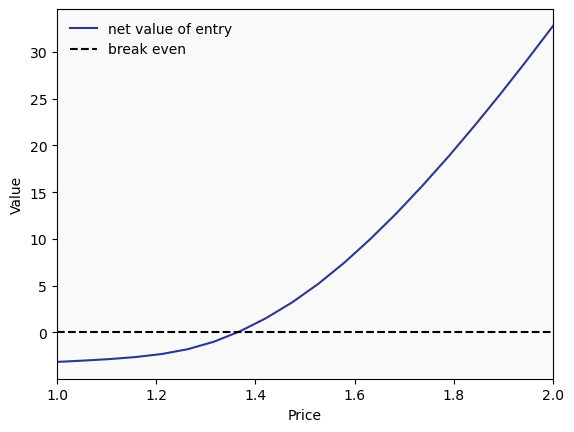

In [63]:
# Net entry value as a function of price.
pmin, pmax, pnum = 1.0, 2.0, 20
p_vec = jnp.linspace(pmin, pmax, pnum)
entry_vals = []
Vstar = jnp.zeros_like(grids.zgrid) # initial condition at first price guess
for i, p in enumerate(p_vec):
    entry_val, Vstar = compute_net_entry_value(p, Vstar, params, grids)
    entry_vals.append(entry_val)

fig, ax = plt.subplots()

ax.plot(p_vec, entry_vals, label='net value of entry', color=colors[0])
ax.plot(p_vec, jnp.zeros_like(p_vec), 'k', ls='--', label='break even')

ax.legend(frameon=False)
ax.set_facecolor('#F9F9F9')
ax.set_xlabel('Price')
ax.set_ylabel('Value')
ax.set_xmargin(0)

plt.show()

In [65]:
%%time
pstar, Vstar, zstar, z_sample, s, Mstar = compute_equilibrium_prices_and_quantities(model)

CPU times: total: 31.2 s
Wall time: 14.2 s


In [66]:
pstar

1.3638267517089844

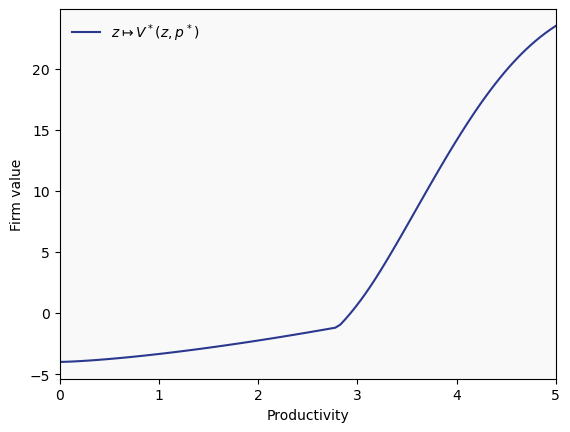

In [70]:
# Plot the value function Vstar.
fig, ax = plt.subplots()

ax.plot(grids.zgrid, Vstar, label=r'$z \mapsto V^*(z, p^*)$', color=colors[0])

ax.legend(frameon=False)
ax.set_facecolor('#F9F9F9')
ax.set_xlabel('Productivity')
ax.set_ylabel('Firm value')
ax.set_xmargin(0)

plt.show()

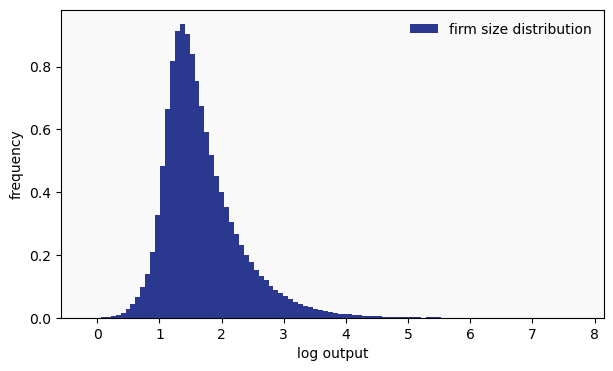

In [71]:
# Plot the firm size distribution, with firm size measured by output.
output_dist = q(z_sample, pstar, params)

fig, ax = plt.subplots(figsize=(7, 4))

ax.hist(jnp.log(output_dist), bins=100, density=True, label='firm size distribution', color=colors[0])

ax.legend(frameon=False)
ax.set_facecolor('#F9F9F9')
ax.set_xlabel('log output')
ax.set_ylabel('frequency')

plt.show()

In [86]:
def ECCDF(data):
    """
    Return a function that implements the ECCDF given the data.
    """
    def eccdf(x):
        return jnp.mean(data > x)
    return eccdf

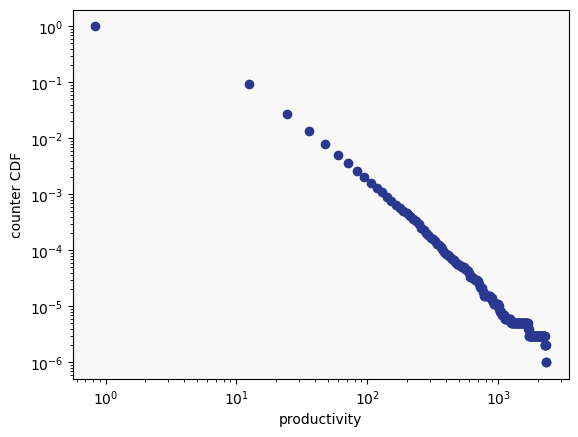

In [87]:
# Plot the empirical counter CDF of the output distribution.
eccdf = ECCDF(output_dist)

ϵ = 1e-10
xgrid = jnp.linspace(output_dist.min()+ϵ, output_dist.max()-ϵ, 200)
y = [eccdf(x) for x in xgrid]

fig, ax = plt.subplots()

ax.loglog(xgrid, y, 'o', label='ECCDF', color=colors[0])

ax.set_facecolor('#F9F9F9')
ax.set_xlabel('productivity')
ax.set_ylabel('counter CDF')

plt.show()

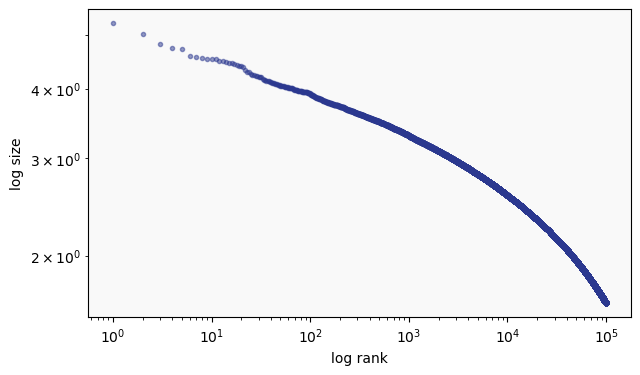

In [94]:
# Plot the same output distribution using a rank-size plot.
# turns out to be nonlinear, which does not suggest a Pareto tail.
# Indeed, we are using a folded normal distribution.

x = jnp.abs(jax.random.normal(jax.random.PRNGKey(42), (1_000_000, )))
rank_data, size_data = qe.rank_size(x, c=0.1)

fig, ax = plt.subplots(figsize=(7, 4))

ax.loglog(rank_data, size_data, 'o', ms=3, alpha=0.5, color=colors[0])

ax.set_facecolor('#F9F9F9')
ax.set_xlabel('log rank')
ax.set_ylabel('log size')

plt.show()

Equilibrium price when c = 2.5 is 1.0
Equilibrium price when c = 2.8 is 1.1
Equilibrium price when c = 3.1 is 1.1
Equilibrium price when c = 3.3 is 1.2
Equilibrium price when c = 3.6 is 1.3
Equilibrium price when c = 3.9 is 1.3
Equilibrium price when c = 4.2 is 1.4
Equilibrium price when c = 4.4 is 1.5
Equilibrium price when c = 4.7 is 1.5
Equilibrium price when c = 5.0 is 1.6


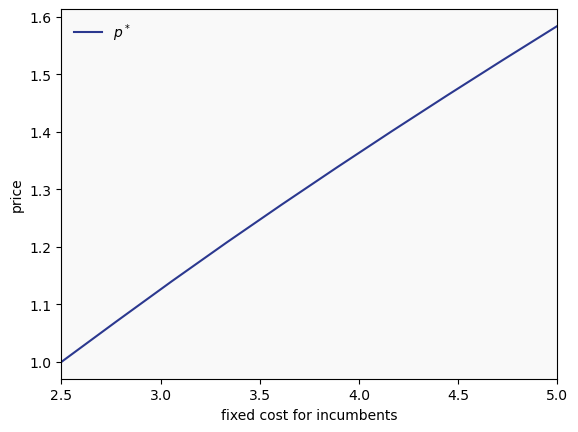

In [95]:
# Investigate relations between fixed operation cost and the equilibrium price.

c_values = jnp.linspace(2.5, 5.0, 10)
eq_prices = []
for i, c in enumerate(c_values):
    model = create_model(c=c)
    pstar, Vstar, zstar, z_sample, s, Mstar = compute_equilibrium_prices_and_quantities(model)
    eq_prices.append(pstar)
    print(f'Equilibrium price when c = {c:.2} is {pstar:.2}')

fig, ax = plt.subplots()

ax.plot(c_values, eq_prices, label='$p^*$', color=colors[0])

ax.legend(frameon=False)
ax.set_facecolor('#F9F9F9')
ax.set_xlabel('fixed cost for incumbents')
ax.set_ylabel('price')
ax.set_xmargin(0)

plt.show()